In [1]:
import tensorflow as tf
from tensorflow.keras import models,layers,datasets,Model,preprocessing
import numpy as np
import math,sys,os,glob
import matplotlib.pyplot as plt
import PIL
import time
from IPython import display

In [2]:
filenames = glob.glob('D:\\UCI\\AstroInfo\\Alex-April-2020-4k\\ps1dr2ZTF_jpg\\**\\*.jpg')
dataj = []
for f in filenames:
    with PIL.Image.open(f) as img:
        d = np.asarray(img)
        dataj.append(tf.cast(d[96:160,96:160] / 255., 'float32'))
vdataj = dataj[:int(len(dataj)/2)]
tdataj = dataj[int(len(dataj)/2):]
dataj = tf.reshape(dataj, (len(dataj),64,64,3))
vdataj = tf.reshape(vdataj, (len(vdataj),64,64,3))
tdataj = tf.reshape(tdataj, (len(tdataj),64,64,3))

In [3]:
train_size = 2000
batch_size = 32
test_size = 2000
train_dataset = (tf.data.Dataset.from_tensor_slices(tdataj)
                 .shuffle(train_size).batch(batch_size))
test_dataset = (tf.data.Dataset.from_tensor_slices(vdataj)
                .shuffle(test_size).batch(batch_size))

In [14]:
class VAE_J(tf.keras.Model):
    def __init__(self, ld):
        super(VAE_J, self).__init__()
        self.latent_dim = ld
        self.encoder = tf.keras.Sequential([
            layers.InputLayer(input_shape=((64,64,3))),
            layers.Conv2D(filters=32, kernel_size=2, strides=(2,2), padding='same', activation='relu'),
            layers.Conv2D(filters=64, kernel_size=2, strides=(2,2), padding='same', activation='relu'),
            layers.Conv2D(filters=128, kernel_size=2, strides=(2,2), padding='same', activation='relu'),
            layers.Flatten(),
            layers.Dense(512),
            layers.Dense(latent_dim+latent_dim)
        ])
        self.decoder = tf.keras.Sequential([
            layers.InputLayer(input_shape=((latent_dim,))),
            layers.Dense(512, activation='relu'),
            layers.Dense(8*8*64, activation='relu'),
            layers.Reshape((8,8,64)),
            layers.Conv2DTranspose(filters=128, kernel_size=2, strides=2, padding='same', activation='relu'),
            layers.Conv2DTranspose(filters=64, kernel_size=2, strides=2, padding='same', activation='relu'),
            layers.Conv2DTranspose(filters=32, kernel_size=2, strides=2, padding='same', activation='relu'),
            layers.Conv2DTranspose(filters=3, kernel_size=2, strides=1, padding='same')
        ])
    
    @tf.function
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(100, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)
    
    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean

    def decode(self, z, apply_sigmoid=False):
        logits = self.decoder(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits

In [15]:
optimizer = tf.keras.optimizers.Adam(.0001)

def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(-.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),axis=raxis)


def compute_loss(model, x):
    beta = 10.0 #1.0 means VAE; greater than 1.0 means beta-VAE
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    x_logit = model.decode(z)
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
    logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
    logpz = log_normal_pdf(z, 0., 0.)
    logqz_x = log_normal_pdf(z, mean, logvar)
    return -tf.reduce_mean(logpx_z + beta*logpz - beta*logqz_x)


@tf.function
def train_step(model, x, optimizer):
    with tf.GradientTape() as tape:
        loss = compute_loss(model, x)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [16]:
def generate_and_save_images_J(model, epoch, test_sample):
    mean, logvar = model.encode(test_sample)
    z = model.reparameterize(mean, logvar)
    predictions = model.sample(z)
    print(predictions.shape)
    fig = plt.figure(figsize=(6, 6))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, :, :, :])
        plt.axis('off')
    '''if epoch % 10 == 0:
        plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))'''
    plt.show()

In [17]:
ex = 16
epochs = 50
latent_dim = 64
assert 32 >= ex
for test_batch in test_dataset.take(1):
    test_sample = test_batch[0:ex, :, :, :]

m = VAE_J(latent_dim)
rand_vector = tf.random.normal(shape=[ex, latent_dim])

Epoch: 50, Test set ELBO: -8062.5537109375, time elapse for current epoch: 0.7689108848571777
(16, 64, 64, 3)


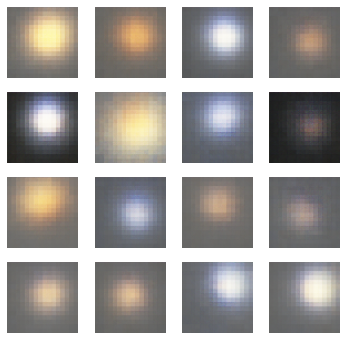

In [18]:
generate_and_save_images_J(m, 0, test_sample)
for epoch in range(1, epochs + 1):
    start_time = time.time()
    for train_x in train_dataset:
        train_step(m, train_x, optimizer)
    end_time = time.time()

    loss = tf.keras.metrics.Mean()
    for test_x in test_dataset:
        loss(compute_loss(m, test_x))
    elbo = -loss.result()
    display.clear_output(wait=False)
    print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'
          .format(epoch, elbo, end_time - start_time))
    generate_and_save_images_J(m, epoch, test_sample)

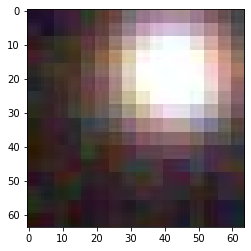

In [19]:
plt.imshow(tf.reshape(dataj[0], (64,64,3)))

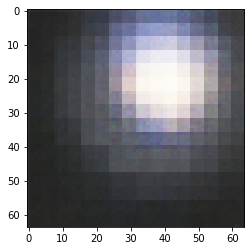

In [20]:
tme, tlo = m.encode(tf.reshape(dataj[0], (1,64,64,3)))
tou = m.reparameterize(tme,tlo)
plt.imshow(tf.reshape(m.decode(tou, True), (64,64,3)))